In [7]:
!du -L ../jigsaw-toxic-comment-classification-challenge/*

416	../jigsaw-toxic-comment-classification-challenge/Data Exploration.ipynb
152	../jigsaw-toxic-comment-classification-challenge/clean.png
12272	../jigsaw-toxic-comment-classification-challenge/sample_submission.csv
117888	../jigsaw-toxic-comment-classification-challenge/test.csv
9728	../jigsaw-toxic-comment-classification-challenge/test_labels.csv
134384	../jigsaw-toxic-comment-classification-challenge/train.csv


In [8]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

# Data Exploration

## Check the basic info of the dataset

In [9]:
#importing the dataset
train=pd.read_csv("../jigsaw-toxic-comment-classification-challenge/train.csv")
test=pd.read_csv("../jigsaw-toxic-comment-classification-challenge/test.csv")

In [10]:
#take a peak
print(train.tail(10))
print(train.info())

                      id                                       comment_text  \
159561  ffd2e85b07b3c7e4  "\nNo he did not, read it again (I would have ...   
159562  ffd72e9766c09c97  "\n Auto guides and the motoring press are not...   
159563  ffe029a7c79dc7fe  "\nplease identify what part of BLP applies be...   
159564  ffe897e7f7182c90  Catalan independentism is the social movement ...   
159565  ffe8b9316245be30  The numbers in parentheses are the additional ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
159561      0             0        0       0       0        

In [11]:
# Check the number of each type of toxic comments
print("Total number of toxic comments:",train[train['toxic']==1].shape[0])
print("Non Toxic: ",train.toxic.value_counts()[0])
print("Toxic: ",train.toxic.value_counts()[1])
print("\n")
print("Non severe_toxic: ",train.severe_toxic.value_counts()[0])
print("severe_toxic    : ",train.severe_toxic.value_counts()[1])
print("Non obscene: ",train.obscene.value_counts()[0])
print("obscene    : ",train.obscene.value_counts()[1])
print("Non threat: ",train.threat.value_counts()[0])
print("threat    : ",train.threat.value_counts()[1])
print("Non insult: ",train.insult.value_counts()[0])
print("insult    : ",train.insult.value_counts()[1])
print("Non identity_hate: ",train.identity_hate.value_counts()[0])
print("identity_hate    : ",train.identity_hate.value_counts()[1])

Total number of toxic comments: 15294
Non Toxic:  144277
Toxic:  15294


Non severe_toxic:  157976
severe_toxic    :  1595
Non obscene:  151122
obscene    :  8449
Non threat:  159093
threat    :  478
Non insult:  151694
insult    :  7877
Non identity_hate:  158166
identity_hate    :  1405


In [12]:
#calculate the ratio of training set and test
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


## Class Imbalance

In [13]:
#caculate the ratio of clean comments
print("Tags & Numbers:")
x=train.iloc[:,2:].sum()  #make a statics of each tag of comments
print(x)
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)  #add the value from the 3st to the end columns 
train['clean']=(rowsums==0)
#count number of clean entries
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Tags & Numbers:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
Total comments =  159571
Total clean comments =  143346
Total tags = 35098


Total comments - Total clean comments = 16225 < Total tags = 35098. Some comments are multi-tagged.

In [14]:
#check the missing values in training set and test set
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'clean'],
      dtype='object')
[ 15294.   1595.   8449.    478.   7877.   1405. 143346.]


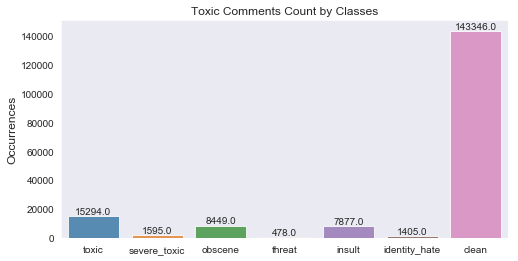

In [15]:
x=train.iloc[:,2:].sum()
print(x.index)
print(x.values)
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Toxic Comments Count by Classes")
plt.ylabel('Occurrences', fontsize=12)
# plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')  #rect.get_x() + rect.get_width()/2: write at the central

plt.show()

Conclusion:
    1. The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
    2. Some comments are multi-tagged

## Multi-tagging

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


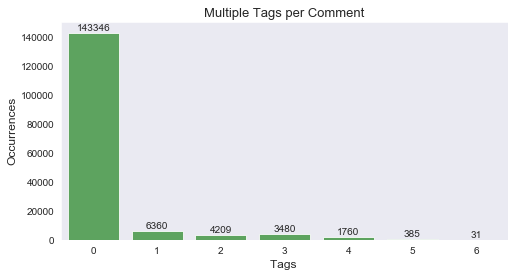

In [16]:
x=rowsums.value_counts()
print(x)

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple Tags per Comment",fontsize=13)
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Only 10.2% of the total comments have some sort of toxicity in them. There are certain comments(20) that are marked as all of the above!

### Which tags go together?

Now let's have a look at how often the tags occur together. A good indicator of that would be a correlation plot.

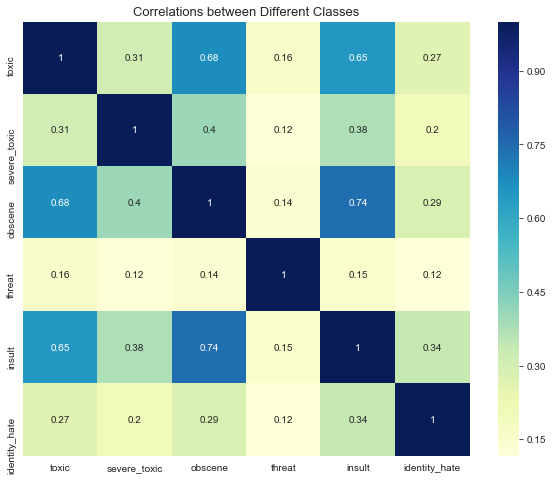

In [17]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
plt.title("Correlations between Different Classes",fontsize=13)
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True,cmap="YlGnBu")

The above plot indicates a pattern of co-occurance but Pandas's default Corr function which uses Pearson correlation does not apply here, since the variables invovled are Categorical (binary) variables.

So, to find a pattern between two categorical variables we can use other tools like

- Confusion matrix/Crosstab
- Cramer's V Statistic: an extension of the chi-square test where the extent/strength of association is also measured

In [18]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [19]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes.

Some interesting observations:

- A Severe toxic comment is always toxic
- Other classes seem to be a subset of toxic barring a few exceptions

In [20]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [21]:
# Checking for Toxic and Severe toxic for now
# Cramer's V Statistic
import pandas as pd
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.30850290540548614


### Example Comments:

In [22]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])
print("\n")
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])
print("\n")
print("Threat:")
print(train[train.threat==1].iloc[1,1])
#print(train[train.threat==1].iloc[2,1])
print("\n")
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])
#print(train[train.obscene==1].iloc[2,1])
print("\n")
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum 

That was a whole lot of toxicity. Some weird observations:
- Some of the comments are extremely and mere copy paste of the same thing
- Comments can still contain IP addresses (eg:62.158.73.165), usernames (eg:ARKJEDI10) and some mystery numbers (assume to be article-IDs), which can cause huge overfitting

## Wordclouds - Frequent words:

Now, let's take a look at words that are associated with these classes.

Chart Desc: The visuals here are word clouds (ie) more frequent words appear bigger. A cool way to create word clouds with funky pics is given here. It involves the following steps.

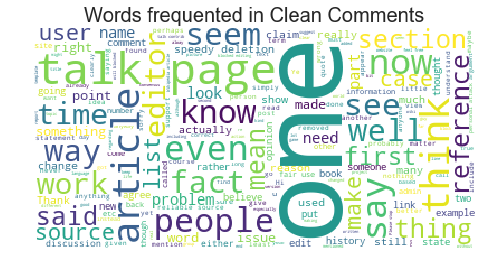

In [47]:
#clean comments
# clean_mask=np.array(Image.open("../input/imagesforkernal/safe-zone.png"))
# clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=2000)
wc.generate(" ".join(text))
c=plt.figure(figsize=(8,7))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()
c.savefig('clean.png', dpi = 1000)

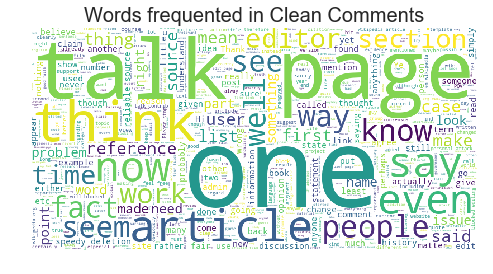

In [51]:
#clean comments
clean_mask=np.array(Image.open("../jigsaw-toxic-comment-classification-challenge/clean.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(width=800, height=400,background_color="white",max_words=2000)
# wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(8,7))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [ ]:
# wordcloud: toxic	severe_toxic	obscene	threat	insult	identity_hate

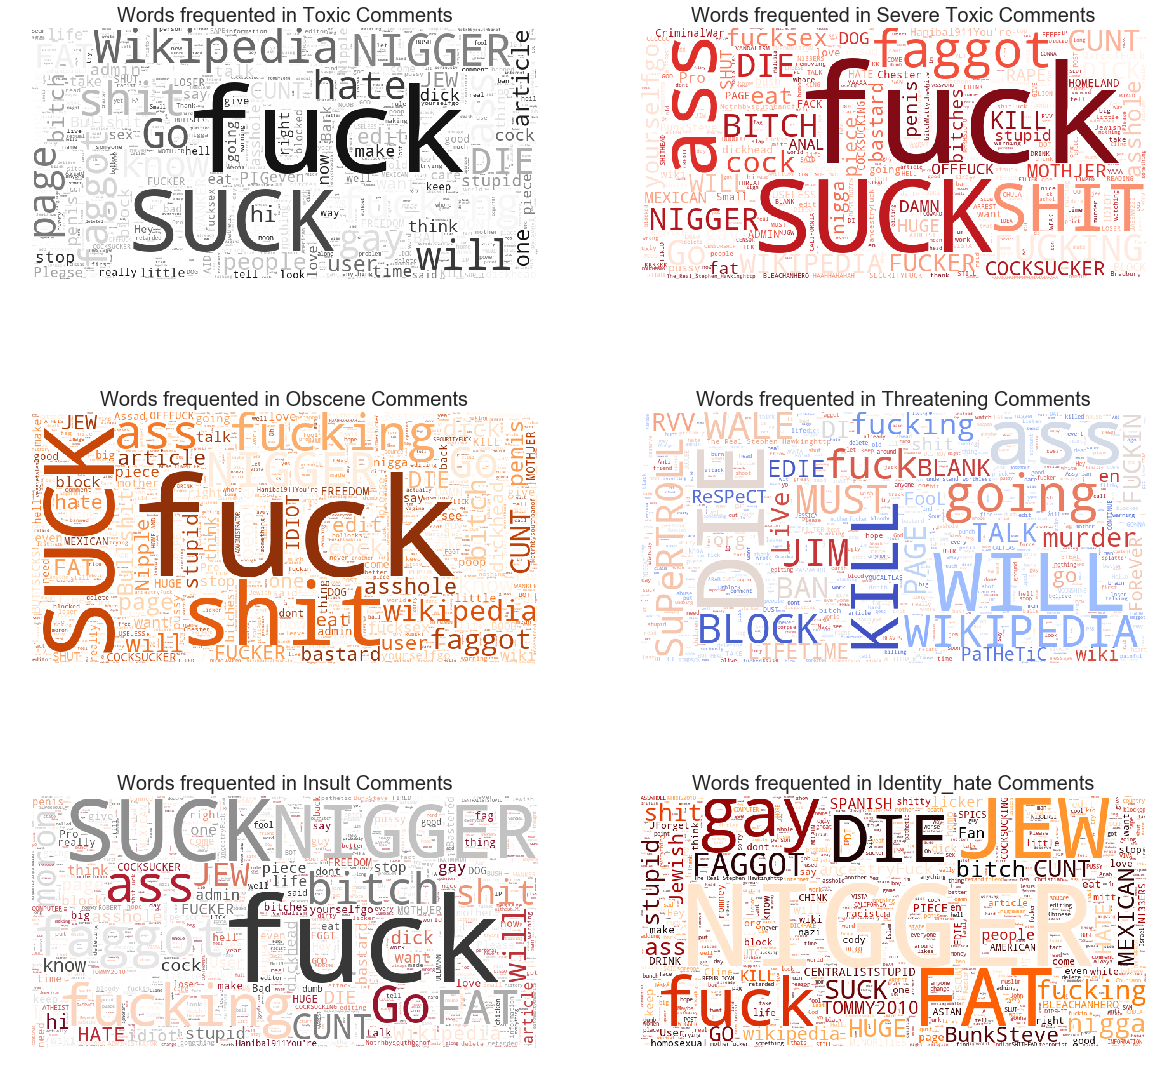

In [53]:
#wordcloud for toxic comments
# toxic_mask=np.array(Image.open("../jigsaw-toxic-comment-classification-challenge/clean.png"))
# toxic_mask=toxic_mask[:,:,1]
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(width=800, height=400,background_color="white",max_words=4000,collocations=False)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(321)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Greys' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(322)
# severe_toxic_mask=np.array(Image.open("../input/imagesforkernal/bomb.png"))
# severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(width=800, height=400,background_color="white",max_words=2000,collocations=False)
# wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

# obscene
plt.subplot(323)
# obscene_mask=np.array(Image.open("../input/imagesforkernal/bomb.png"))
# obscene_mask=obscene_toxic_mask[:,:,1]
subset=train[train.obscene==1]
text=subset.comment_text.values
wc= WordCloud(width=800, height=400,background_color="white",max_words=2000,collocations=False)
# wc= WordCloud(background_color="black",max_words=2000,mask=obscene_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Oranges' , random_state=244), alpha=0.98)

# Threat comments
plt.subplot(324)
# threat_mask=np.array(Image.open("../input/imagesforkernal/anger.png"))
# threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(width=800, height=400,background_color="white",max_words=2000,collocations=False)
# wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'coolwarm' , random_state=2534), alpha=0.98)

#insult
plt.subplot(325)
# insult_mask=np.array(Image.open("../input/imagesforkernal/swords.png"))
# insult_mask=insult_mask[:,:,1]
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(width=800, height=400,background_color="white",max_words=2000,collocations=False)
# wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'RdGy' , random_state=244), alpha=0.98)

#identity_hate
plt.subplot(326)
# identity_hate_mask=np.array(Image.open("../input/imagesforkernal/swords.png"))
# identity_hate_mask=identity_hate_mask[:,:,1]
subset=train[train.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(width=800, height=400,background_color="white",max_words=2000,collocations=False)
# wc= WordCloud(background_color="black",max_words=2000,mask=identity_hate_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Identity_hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_heat' , random_state=244), alpha=0.98)
plt.show()

# Feature engineering:

## Leaky features

In [54]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [55]:
#Leaky features
df['ip']=df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
#count of ip addresses
df['count_ip']=df["ip"].apply(lambda x: len(x))

#links
df['link']=df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
#count of links
df['count_links']=df["link"].apply(lambda x: len(x))

#article ids
df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))

#username
##regex for Match anything with [[User: ---------- ]]
# regexp = re.compile("\[\[User:(.*)\|")
df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
#count of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))
#check if features are created
#df.username[df.count_usernames>0]

# Leaky Ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x : str(x)))


# Leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

In [56]:
df[df.count_usernames!=0].comment_text.iloc[0]

'2010]]\n[[User talk:Wikireader41/Archive4|Archive 5-Mar 15'

In [57]:
# check few names
cv.get_feature_names()[120:130]

['destruction',
 'diablo',
 'diligent',
 'dland',
 'dlohcierekim',
 'dodo',
 'dominick',
 'douglas',
 'dpl',
 'dr']

## Leaky Feature Stability

In [58]:
leaky_feats=df[["ip","link","article_id","username","count_ip","count_links","count_usernames","article_id_flag"]]
leaky_feats_train=leaky_feats.iloc[:train.shape[0]]
leaky_feats_test=leaky_feats.iloc[train.shape[0]:]

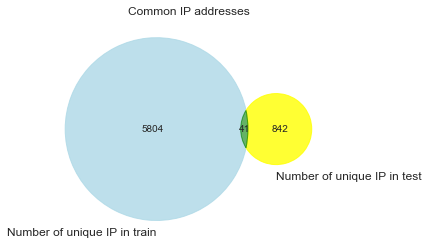

In [82]:
#filterout the entries without ips
train_ips=leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips=leaky_feats_test.ip[leaky_feats_test.count_ip!=0]
#get the unique list of ips in test and train datasets
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
common_ip_list=list(set(train_ip_list).intersection(test_ip_list))
plt.title("Common IP addresses")
ven=venn.venn2(subsets={'10':len(train_ip_list),'01':len(test_ip_list),'11':len(common_ip_list)},set_labels=("Number of unique IP in train","Number of unique IP in test"))
ven.get_patch_by_id('10').set_alpha(0.8)
ven.get_patch_by_id('10').set_color('lightblue')
ven.get_patch_by_id('01').set_alpha(0.8)
ven.get_patch_by_id('01').set_color('yellow')
ven.get_patch_by_id('11').set_alpha(0.6)
ven.get_patch_by_id('11').set_color('green')
plt.show()

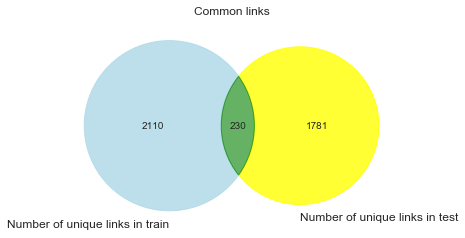

In [83]:
#filterout the entries without links
train_links=leaky_feats_train.link[leaky_feats_train.count_links!=0]
test_links=leaky_feats_test.link[leaky_feats_test.count_links!=0]
#get the unique list of ips in test and train datasets
train_links_list=list(set([a for b in train_links.tolist() for a in b]))
test_links_list=list(set([a for b in test_links.tolist() for a in b]))

# get common elements
common_links_list=list(set(train_links_list).intersection(test_links_list))
plt.title("Common links")
ven=venn.venn2(subsets={'10':len(train_links_list),'01':len(test_links_list),'11':len(common_links_list)},
           set_labels=("Number of unique links in train","Number of unique links in test"))
ven.get_patch_by_id('10').set_alpha(0.8)
ven.get_patch_by_id('10').set_color('lightblue')
ven.get_patch_by_id('01').set_alpha(0.8)
ven.get_patch_by_id('01').set_color('yellow')
ven.get_patch_by_id('11').set_alpha(0.6)
ven.get_patch_by_id('11').set_color('green')
plt.show()

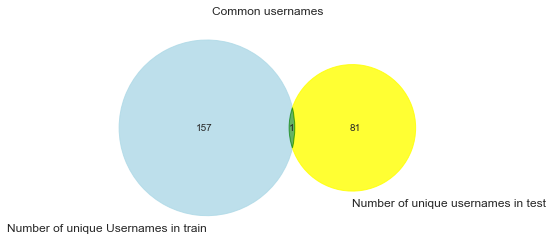

In [84]:
#filterout the entries without users
train_users=leaky_feats_train.username[leaky_feats_train.count_usernames!=0]
test_users=leaky_feats_test.username[leaky_feats_test.count_usernames!=0]
#get the unique list of ips in test and train datasets
train_users_list=list(set([a for b in train_users.tolist() for a in b]))
test_users_list=list(set([a for b in test_users.tolist() for a in b]))

# get common elements
common_users_list=list(set(train_users_list).intersection(test_users_list))
plt.title("Common usernames")
ven=venn.venn2(subsets={'10':len(train_users_list),'01':len(test_users_list),'11':len(common_users_list)},
           set_labels=("Number of unique Usernames in train","Number of unique usernames in test"))
ven.get_patch_by_id('10').set_alpha(0.8)
ven.get_patch_by_id('10').set_color('lightblue')
ven.get_patch_by_id('01').set_alpha(0.8)
ven.get_patch_by_id('01').set_color('yellow')
ven.get_patch_by_id('11').set_alpha(0.6)
ven.get_patch_by_id('11').set_color('green')
plt.show()

The feature stability (aka) the reoccurance of train dataset usernames in the test dataset seems to be minimal. We can just use the intersection (eg) the common IPs/links for test and train in our feature engineering.

Another usecase for the list of IPs would be to find out if they are a part of the blocked IP list

In [86]:
#https://en.wikipedia.org/wiki/Wikipedia:Database_reports/Indefinitely_blocked_IPs)

blocked_ips=["216.102.6.176",
"216.120.176.2",
"203.25.150.5",
"203.217.8.30",
"66.90.101.58",
"125.178.86.75",
"210.15.217.194",
"69.36.166.207",
"213.25.24.253",
"24.60.181.235",
"71.204.14.32",
"216.91.92.18",
"212.219.2.4",
"194.74.190.162",
"64.15.152.246",
"59.100.76.166",
"146.145.221.129",
"146.145.221.130",
"74.52.44.34",
"68.5.96.201",
"65.184.176.45",
"209.244.43.209",
"82.46.9.168",
"209.200.236.32",
"209.200.229.181",
"202.181.99.22",
"220.233.226.170",
"212.138.64.178",
"220.233.227.249",
"72.14.194.31",
"72.249.45.0/24",
"72.249.44.0/24",
"80.175.39.213",
"81.109.164.45",
"64.157.15.0/24",
"208.101.10.54",
"216.157.200.254",
"72.14.192.14",
"204.122.16.13",
"217.156.39.245",
"210.11.188.16",
"210.11.188.17",
"210.11.188.18",
"210.11.188.19",
"210.11.188.20",
"64.34.27.153",
"209.68.139.150",
"152.163.100.0/24",
"65.175.48.2",
"131.137.245.197",
"131.137.245.199",
"131.137.245.200",
"64.233.172.37",
"66.99.182.25",
"67.43.21.12",
"66.249.85.85",
"65.175.134.11",
"201.218.3.198",
"193.213.85.12",
"131.137.245.198",
"83.138.189.74",
"72.14.193.163",
"66.249.84.69",
"209.204.71.2",
"80.217.153.189",
"83.138.136.92",
"83.138.136.91",
"83.138.189.75",
"83.138.189.76",
"212.100.250.226",
"212.100.250.225",
"212.159.98.189",
"87.242.116.201",
"74.53.243.18",
"213.219.59.96/27",
"212.219.82.37",
"203.38.149.226",
"66.90.104.22",
"125.16.137.130",
"66.98.128.0/17",
"217.33.236.2",
"24.24.200.113",
"152.22.0.254",
"59.145.89.17",
"71.127.224.0/20",
"65.31.98.71",
"67.53.130.69",
"204.130.130.0/24",
"72.14.193.164",
"65.197.143.214",
"202.60.95.235",
"69.39.89.95",
"88.80.215.14",
"216.218.214.2",
"81.105.175.201",
"203.108.239.12",
"74.220.207.168",
"206.253.55.206",
"206.253.55.207",
"206.253.55.208",
"206.253.55.209",
"206.253.55.210",
"66.64.56.194",
"70.91.90.226",
"209.60.205.96",
"202.173.191.210",
"169.241.10.83",
"91.121.195.205",
"216.70.136.88",
"72.228.151.208",
"66.197.167.120",
"212.219.232.81",
"208.86.225.40",
"63.232.20.2",
"206.219.189.8",
"212.219.14.0/24",
"165.228.71.6",
"99.230.151.129",
"72.91.11.99",
"173.162.177.53",
"60.242.166.182",
"212.219.177.34",
"12.104.27.5",
"85.17.92.13",
"91.198.174.192/27",
"155.246.98.61",
"71.244.123.63",
"81.144.152.130",
"198.135.70.1",
"71.255.126.146",
"74.180.82.59",
"206.158.2.80",
"64.251.53.34",
"24.29.92.238",
"76.254.235.105",
"68.96.242.239",
"203.202.234.226",
"173.72.89.88",
"87.82.229.195",
"68.153.245.37",
"216.240.128.0/19",
"72.46.129.44",
"66.91.35.165",
"82.71.49.124",
"69.132.171.231",
"75.145.183.129",
"194.80.20.237",
"98.207.253.170",
"76.16.222.162",
"66.30.100.130",
"96.22.29.23",
"76.168.140.158",
"202.131.166.252",
"89.207.212.99",
"81.169.155.246",
"216.56.8.66",
"206.15.235.10",
"115.113.95.20",
"204.209.59.11",
"27.33.141.67",
"41.4.65.162",
"99.6.65.6",
"60.234.239.169",
"2620:0:862:101:0:0:2:0/124",
"183.192.165.31",
"50.68.6.12",
"37.214.82.134",
"96.50.0.230",
"60.231.28.109",
"64.90.240.50",
"49.176.97.12",
"209.80.150.137",
"24.22.67.116",
"206.180.81.2",
"195.194.39.100",
"87.41.52.6",
"169.204.164.227",
"50.137.55.117",
"50.77.84.161",
"90.202.230.247",
"186.88.129.224",
"2A02:EC80:101:0:0:0:2:0/124",
"142.4.117.177",
"86.40.105.198",
"120.43.20.149",
"198.199.64.0/18",
"192.34.56.0/21",
"192.81.208.0/20",
"2604:A880:0:0:0:0:0:0/32",
"108.72.107.229",
"2602:306:CC2B:7000:41D3:B92D:731C:959D",
"185.15.59.201",
"180.149.1.229",
"207.191.188.66",
"210.22.63.92",
"117.253.196.217",
"119.160.119.172",
"90.217.133.223",
"194.83.8.3",
"194.83.164.22",
"217.23.228.149",
"65.18.58.1",
"168.11.15.2",
"65.182.127.31",
"207.106.153.252",
"64.193.88.2",
"152.26.71.2",
"199.185.67.179",
"117.90.240.73",
"108.176.58.170",
"195.54.40.28",
"185.35.164.109",
"192.185.0.0/16",
"2605:E000:1605:C0C0:3D3D:A148:3039:71F1",
"107.158.0.0/16",
"85.159.232.0/21",
"69.235.4.10",
"86.176.166.206",
"108.65.152.51",
"10.4.1.0/24",
"103.27.227.139",
"188.55.31.191",
"188.53.13.34",
"176.45.58.252",
"176.45.22.37",
"24.251.44.140",
"108.200.140.191",
"117.177.169.4",
"72.22.162.38",
"24.106.242.82",
"79.125.190.93",
"107.178.200.1",
"123.16.244.246",
"83.228.167.87",
"128.178.197.53",
"14.139.172.18",
"207.108.136.254",
"184.152.17.217",
"186.94.29.73",
"217.200.199.2",
"66.58.141.104",
"166.182.81.30",
"89.168.206.116",
"92.98.163.145",
"77.115.31.71",
"178.36.118.74",
"157.159.10.14",
"103.5.212.139",
"203.174.180.226",
"69.123.252.95",
"199.200.123.233",
"121.45.89.82",
"71.228.87.155",
"68.189.67.92",
"216.161.176.152",
"98.17.30.139",
"2600:1006:B124:84BD:0:0:0:103",
"117.161.0.0/16",
"12.166.68.34",
"96.243.149.64",
"74.143.90.218",
"76.10.176.221",
"104.250.128.0/19",
"185.22.183.128/25",
"89.105.194.64/26",
"202.45.119.0/24",
"73.9.140.64",
"164.127.71.72",
"50.160.129.2",
"49.15.213.207",
"83.7.192.0/18",
"201.174.63.79",
"2A02:C7D:4643:8F00:D09D:BE1:D2DE:BB1F",
"125.60.195.230",
"49.145.113.145",
"168.18.160.134",
"72.193.218.222",
"199.216.164.10",
"120.144.130.89",
"104.130.67.208",
"50.160.221.147",
"163.47.141.50",
"91.200.12.136",
"83.222.0.0/19",
"67.231.16.0/20",
"72.231.0.196",
"180.216.68.197",
"183.160.178.135",
"183.160.176.16",
"24.25.221.150",
"92.222.109.43",
"142.134.243.215",
"216.181.221.72",
"113.205.170.110",
"74.142.2.98",
"192.235.8.3",
"2402:4000:BBFC:36FC:E469:F2F0:9351:71A0",
"80.244.81.191",
"2607:FB90:1377:F765:D45D:46BF:81EA:9773",
"2600:1009:B012:7D88:418B:54BA:FCBC:4584",
"104.237.224.0/19",
"2600:1008:B01B:E495:C05A:7DD3:926:E83C",
"168.8.249.234",
"162.211.179.36",
"138.68.0.0/16",
"145.236.37.195",
"67.205.128.0/18",
"2A02:C7D:2832:CE00:B914:19D6:948D:B37D",
"107.77.203.212",
"2607:FB90:65C:A136:D46F:23BA:87C2:3D10",
"2A02:C7F:DE2F:7900:5D64:E991:FFF0:FA93",
"82.23.32.186",
"106.76.243.74",
"82.33.48.223",
"180.216.160.0/19",
"94.102.184.35",
"94.102.184.26",
"109.92.162.54",
"2600:8800:7180:BF00:4C27:4591:347C:736C",
"178.41.186.50",
"184.97.134.128",
"176.221.32.0/22",
"207.99.40.142",
"109.97.241.134",
"82.136.64.19",
"91.236.74.119",
"197.210.0.0/16",
"173.230.128.0/19",
"162.216.16.0/22",
"80.111.222.211",
"191.37.28.21",
"124.124.103.194",
"50.207.7.198",
"220.233.131.98",
"107.77.241.11",
"68.112.39.0/27",
"173.236.128.0/17",
"49.49.240.24",
"96.31.10.178",
"50.251.229.75"]

In [87]:
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
blocked_ip_list_train=list(set(train_ip_list).intersection(blocked_ips))
blocked_ip_list_test=list(set(test_ip_list).intersection(blocked_ips))

print("There are",len(blocked_ip_list_train),"blocked IPs in train dataset")
print("There are",len(blocked_ip_list_test),"blocked IPs in test dataset")

There are 6 blocked IPs in train dataset
There are 0 blocked IPs in test dataset


An interesting but somewhat insignificant finding. There are 6 blocked IP mentions in the comments overall.

Anyways, moving on to cleaning the dataset.

In [88]:
end_time=time.time()
print("total time till Leaky feats",end_time-start_time)

total time till Leaky feats 117010.14512491226


# Corpus cleaning:

In [89]:
corpus=merge.comment_text

In [90]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

As Markus suggested, we don't convert all the words into lower case.

In [91]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    #comment=comment.lower()  ##temporarily denote
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [92]:
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [93]:
clean(corpus.iloc[12235])

'" NOTE If read , follow link , reader see I cite correctly link I add subject . Vidkun add anotations make read oposite , link show " " official " " line take UGLE . I trap User so-called 3RR , peddle POV . Strangly , ALL " " MASONS " " quiet , leave ‘ ‘ ’ ’ defend factual truth . " " Thanks " " Brethren . Sitting block give ... "'

In [94]:
clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

total time till Cleaning 117503.2730858326
